In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import itertools
from statistics import mean

def getFirstIndex(your_list):
    return next((i for i, _ in enumerate(your_list)), None)

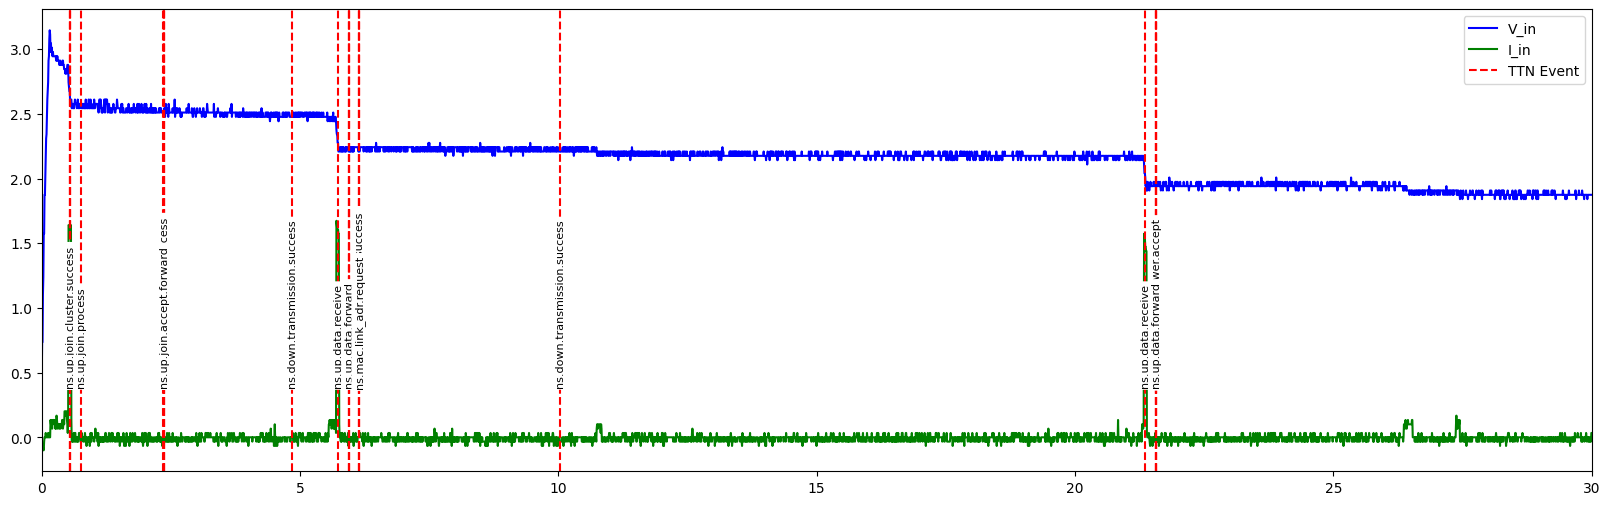

In [5]:
#################################################
#                                               #
#                   TTN Overlay                 #
#                                               #
#################################################

# Note: time logs in TTN have an offset from the scope data which isn't time-stamped (only relative to starting point)

file = '220ms_40mF1'
lower_limit = 0
upper_limit = 30
offset = 0.55

scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

plt.figure(figsize=(20, 6))
plt.plot(scope_data['second'], scope_data['V_in'], color='b', label="V_in")
plt.plot(scope_data['second'], scope_data['I_in'], color='g', label="I_in")

ttn_json = open('./TTN/{}.json'.format(file))
ttn_logs = json.load(ttn_json)
ttn_logs.reverse()
if ttn_logs[0]['name'] == 'synthetic.status.cleared':
    ttn_logs = ttn_logs[1:]
ttn_json.close()

events = []
timestamps = []
reference_time = datetime.fromisoformat(ttn_logs[0]['time'])
for log in ttn_logs:
    events.append(log['name'])
    time_elapsed = (datetime.fromisoformat(log['time']) - reference_time).total_seconds()
    timestamps.append(time_elapsed)

for timestamp, event in zip(timestamps, events):
    time = timestamp+offset
    line = plt.axvline(x=time, color='r', linestyle='--')
    plt.annotate(event, xy=(time, 0), xytext=(time, 0.4), color='black', ha='center', fontsize=8,
        rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))
plt.plot([], [], color='r', linestyle='--', label='TTN Event')

plt.xlim(lower_limit, upper_limit)
plt.legend(loc='upper right')
plt.show()

Range of cluster 1: -0.100418 to 0.033473
Range of cluster 2: 0.066946 to 0.23431
Range of cluster 3: 1.305439 to 1.67364


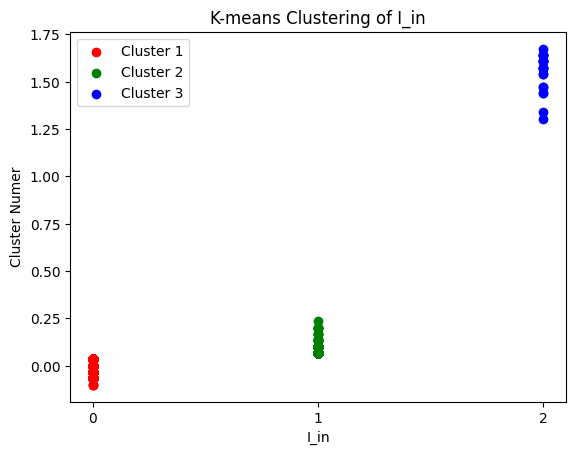

In [6]:
#################################################
#                                               #
#       Cluster to Find Window Thresholds       #
#                                               #
#################################################

scope_data = pd.read_csv('./Scope/{}.csv'.format('220ms_40mF1'))
I_in = scope_data['I_in']

I_in = np.array(I_in).reshape(-1, 1)
initial_centers = np.array([[0.0], [0.1], [1.5]])
kmeans = KMeans(n_clusters=3, init=initial_centers, n_init=1, random_state=0).fit(I_in)
labels = kmeans.labels_


# Print range for each cluster
for i in range(3):
    cluster_data = I_in[labels == i]
    cluster_min = np.min(cluster_data)
    cluster_max = np.max(cluster_data)
    print(f"Range of cluster {i+1}: {cluster_min} to {cluster_max}")

# Plot clusters
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter([i] * sum(labels == i), I_in[labels == i], label=f'Cluster {i+1}', color=colors[i])

plt.title('K-means Clustering of I_in')
plt.xlabel('I_in')
plt.ylabel('Cluster Numer')
plt.xticks([0, 1, 2])
plt.legend()
plt.show()


In [7]:
#################################################
#                                               #
#           Determining Window Bounds           #
#                                               #
#################################################

def get_bounds(file, extend):

    scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

    transmission_windows = []
    rx_windows = []

    def check_valid(element, list, extend, skip=None):   # Returns False if no problems
        if element[1] - element[0] - extend*2 < 3:    # Don't allow overly small windows
            return True
        if skip != None:    # Skip the overlay check
            return True
        overlap = False     # Don't allow RX and transmission windows to coincide
        element_start, element_end = element
        for window in list:
            window_start, window_end = window
            if not (element_end < window_start or element_start > window_end):
                overlap = True
                break
        return overlap

    # Get transmission windows

    start_index = None
    for index, val in enumerate(scope_data['I_in']):
        if val > 1.4:
            if start_index is None:
                start_index = index
        else:
            if start_index is not None:
                window = (start_index - extend, index - 1 + extend)
                if not check_valid(window, transmission_windows, extend):
                    transmission_windows.append(window)
                start_index = None
    if start_index is not None:
        window = (start_index - extend, len(scope_data['I_in']) - 1)
        if not check_valid(window, transmission_windows, extend):
            transmission_windows.append(window)
    transmission_windows = transmission_windows[1:]

    # Return empty lists if transmission never successfully occurred

    if len(transmission_windows) == 0:
        return [[], []]

    # Get RX windows

    start_index = None
    for index, val in enumerate(scope_data['I_in']):
        if index < transmission_windows[0][0] or index > transmission_windows[-1][1] + 900:  # Skip anything before the first transmission and more than ~15s after last transmission
            continue
        if val > 0.06 and val < 0.2:
            if start_index is None:
                start_index = index
        else:
            if start_index is not None and val < 0.03:
                window = (start_index - extend, index - 1 + extend)
                if not check_valid(window, transmission_windows, extend):
                    rx_windows.append(window)
                start_index = None
    if start_index is not None:
        window = (start_index - extend, len(scope_data['I_in']) - 1)
        if not check_valid(window, transmission_windows, extend):
            rx_windows.append(window)

    return [transmission_windows, rx_windows]

def plot_bounds(file, windows, limits=None):

    scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

    plt.figure(figsize=(20, 3))
    plt.plot(scope_data['second'], scope_data['I_in'], color='g', label="I_in")
    plt.plot(scope_data['second'], scope_data['V_in'], color='b', label="V_in")

    transmission_windows, rx_windows = windows

    for window in transmission_windows:
        for index in window:
            timestamp = scope_data['second'].iloc[index]
            plt.axvline(x=timestamp, color='r', linestyle='--')
            plt.annotate(timestamp, xy=(timestamp, 0), xytext=(timestamp, 0.5), color='black', ha='center', fontsize=8,
                rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

    for window in rx_windows:
        for index in window:
            timestamp = scope_data['second'].iloc[index]
            plt.axvline(x=timestamp, color='orange', linestyle='--')
            plt.annotate(timestamp, xy=(timestamp, 0), xytext=(timestamp, 0.5), color='black', ha='center', fontsize=8,
                rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.plot([], [], color='r', linestyle='--', label='Transmission')
    plt.plot([], [], color='orange', linestyle='--', label='RX')
    plt.title('{} Windows of Operation'.format(file))
    plt.legend(loc='upper right')
    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Voltage Measurement (V)')

    if limits != None:
        plt.xlim(limits[0], limits[1])

    plt.show()

In [8]:
#################################################
#                                               #
#         Get AVG Energy Consumptions           #
#                                               #
#################################################

ms = [160, 180, 200, 220]
mF = [10, 20, 30, 40]
combinations = list(itertools.product(ms, mF))
    
rx_avgs = []
tx_avgs = []
for c0, c1 in combinations:
    csv = '{}ms_{}mF1'.format(c0, c1)
    [tx, rx] = get_bounds(csv, 1)
    scope_data = pd.read_csv('./Scope/{}.csv'.format(csv))
    V_in = scope_data['V_in']
    I_in = scope_data['I_in'] / 1.071
    seconds = scope_data['second']
    
    for x0, x1 in rx:
        energy = mean(I_in[x0:x1+1] * V_in[x0:x1+1]) * (seconds[x1]-seconds[x0])
        rx_avgs.append(energy)

    for x0, x1 in tx:
        energy = mean(I_in[x0:x1+1] * V_in[x0:x1+1]) * (seconds[x1]-seconds[x0])
        tx_avgs.append(energy)
        
print("RX avg Joules: ", mean(rx_avgs))        
print("TX avg Joules: ", mean(tx_avgs))


RX avg Joules:  0.01877691455944443
TX avg Joules:  0.13424286975580693


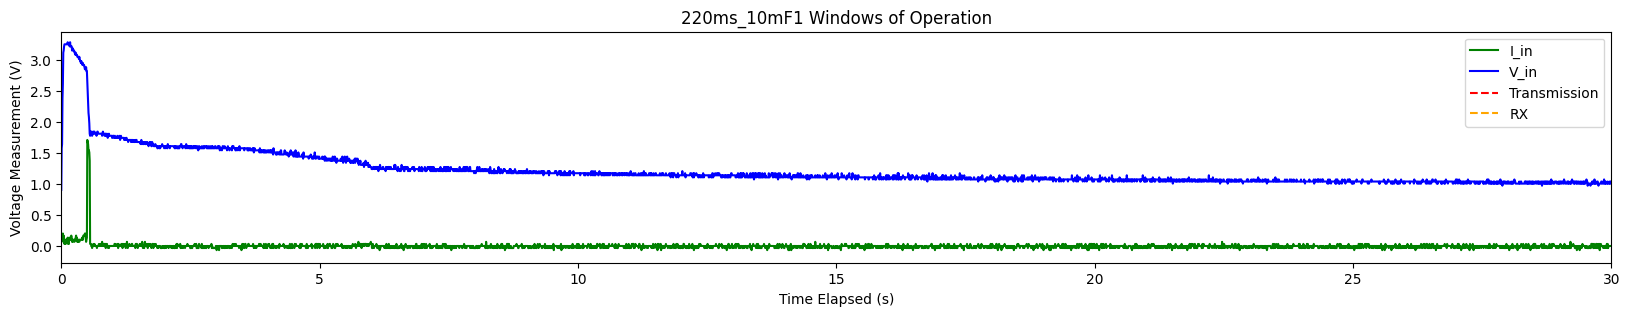

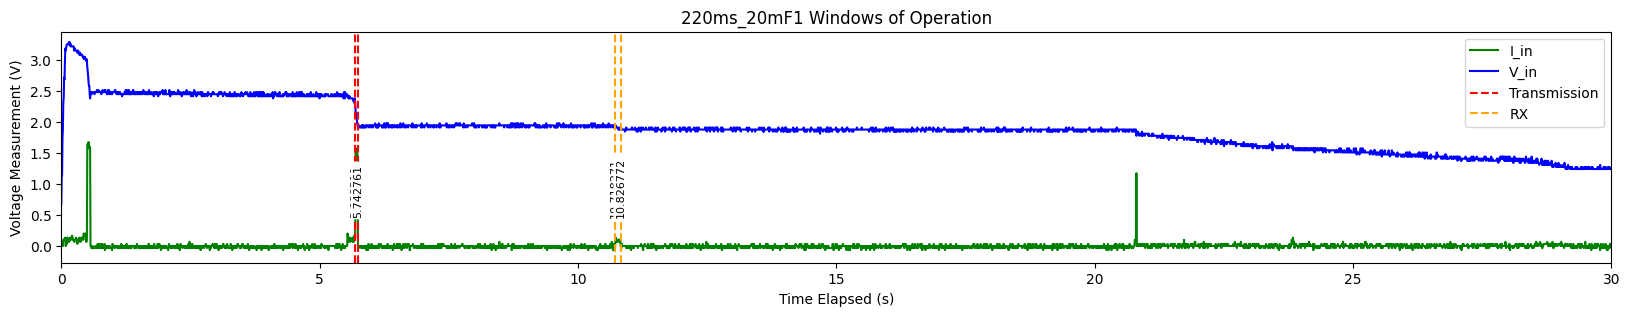

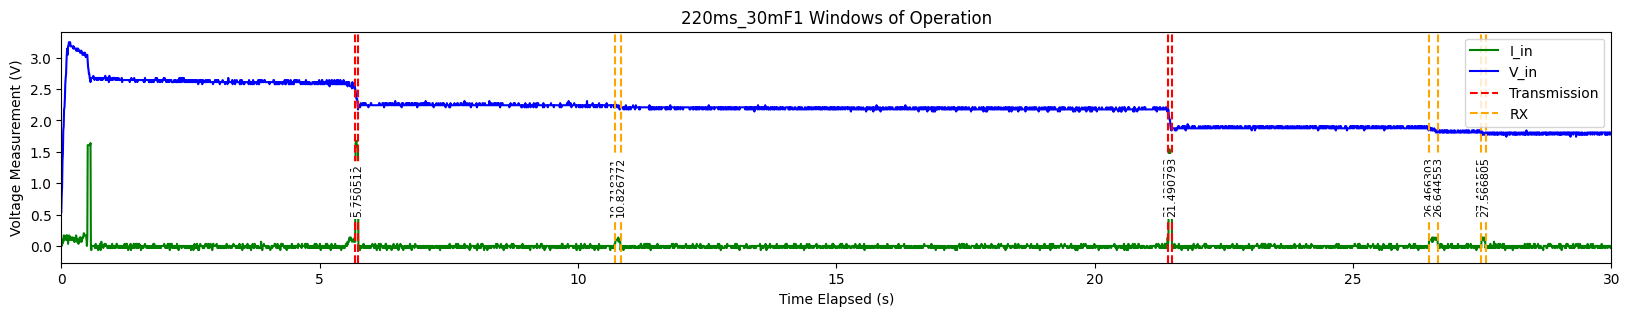

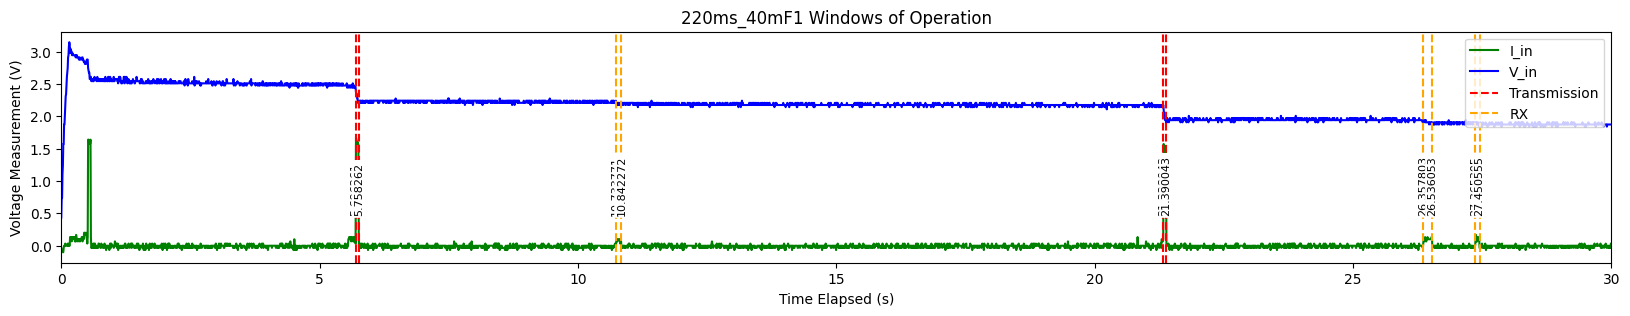

In [9]:
#################################################
#                                               #
#         Plot all C of one Pulse Length        #
#                                               #
#################################################

ms = 220
plot_bounds('{}ms_10mF1'.format(ms), get_bounds('{}ms_10mF1'.format(ms), 1), limits=[0,30])
plot_bounds('{}ms_20mF1'.format(ms), get_bounds('{}ms_20mF1'.format(ms), 1), limits=[0,30])
plot_bounds('{}ms_30mF1'.format(ms), get_bounds('{}ms_30mF1'.format(ms), 1), limits=[0,30])
plot_bounds('{}ms_40mF1'.format(ms), get_bounds('{}ms_40mF1'.format(ms), 1), limits=[0,30])

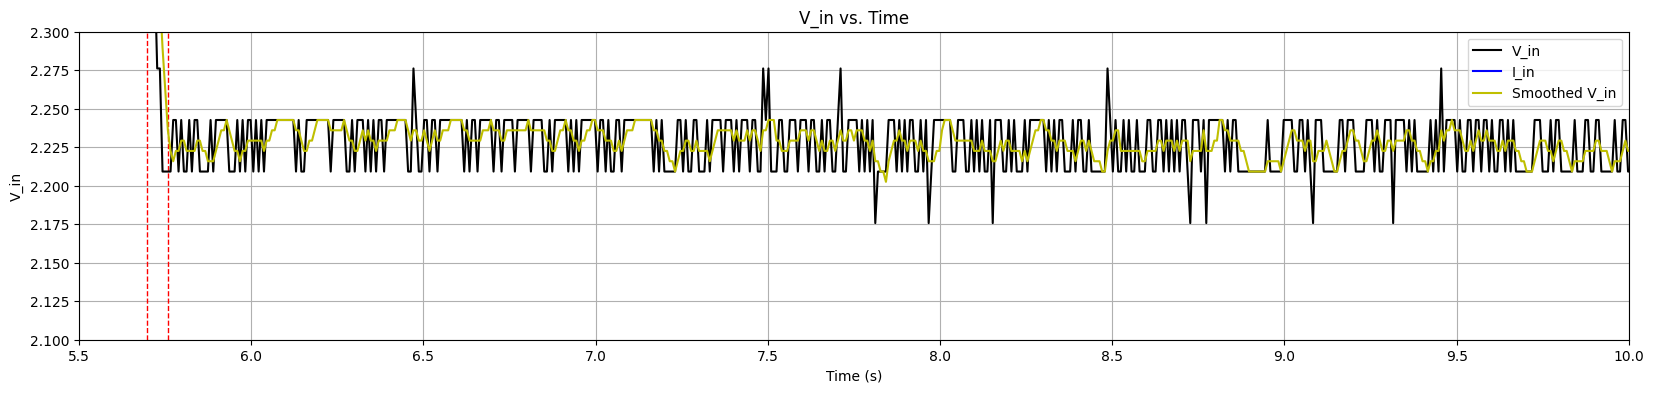

In [40]:
#################################################
#                                               #
#           Prepare for Optimization            #
#                                               #
#################################################

ms = 220
C = 0.040
V = 0
R_shunt = 1.071
initial_voltage = 0

extend = 1
window_size = 5

file = '{}ms_{}mF1'.format(ms, int(C*1000))
transmission_windows, rx_windows = get_bounds(file, extend)
scope_data = pd.read_csv('./Scope/{}.csv'.format(file))
V_in = scope_data['V_in']
seconds = scope_data['second']

# Get ranges of each RX and TX window
window_indices = []
for start, end in transmission_windows + rx_windows:
    window_indices.extend([start, end])
window_indices.sort()

# Smooth the data (if you want, put window_size > 1)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_V_in = moving_average(V_in, window_size=window_size)
adjusted_seconds = seconds[window_size-1:]
adjusted_V_in =  V_in[window_size-1:]

# Plot smoothed_V_in vs adjusted_seconds
plt.figure(figsize=(20, 4))
for index in window_indices: 
    plt.axvline(x=seconds[index], color='r', linestyle='--', linewidth=1)
plt.plot(seconds, V_in, color='black', label="V_in")
plt.plot(seconds, scope_data['I_in'], color='b', label="I_in")
plt.plot(adjusted_seconds, smoothed_V_in, color='y', label="Smoothed V_in")
plt.title('V_in vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('V_in')
plt.xlim(5.5, 10)
# plt.xlim(5.5, 6.0)
plt.ylim(2.1, 2.3)
plt.grid(True)
plt.legend()
plt.show()

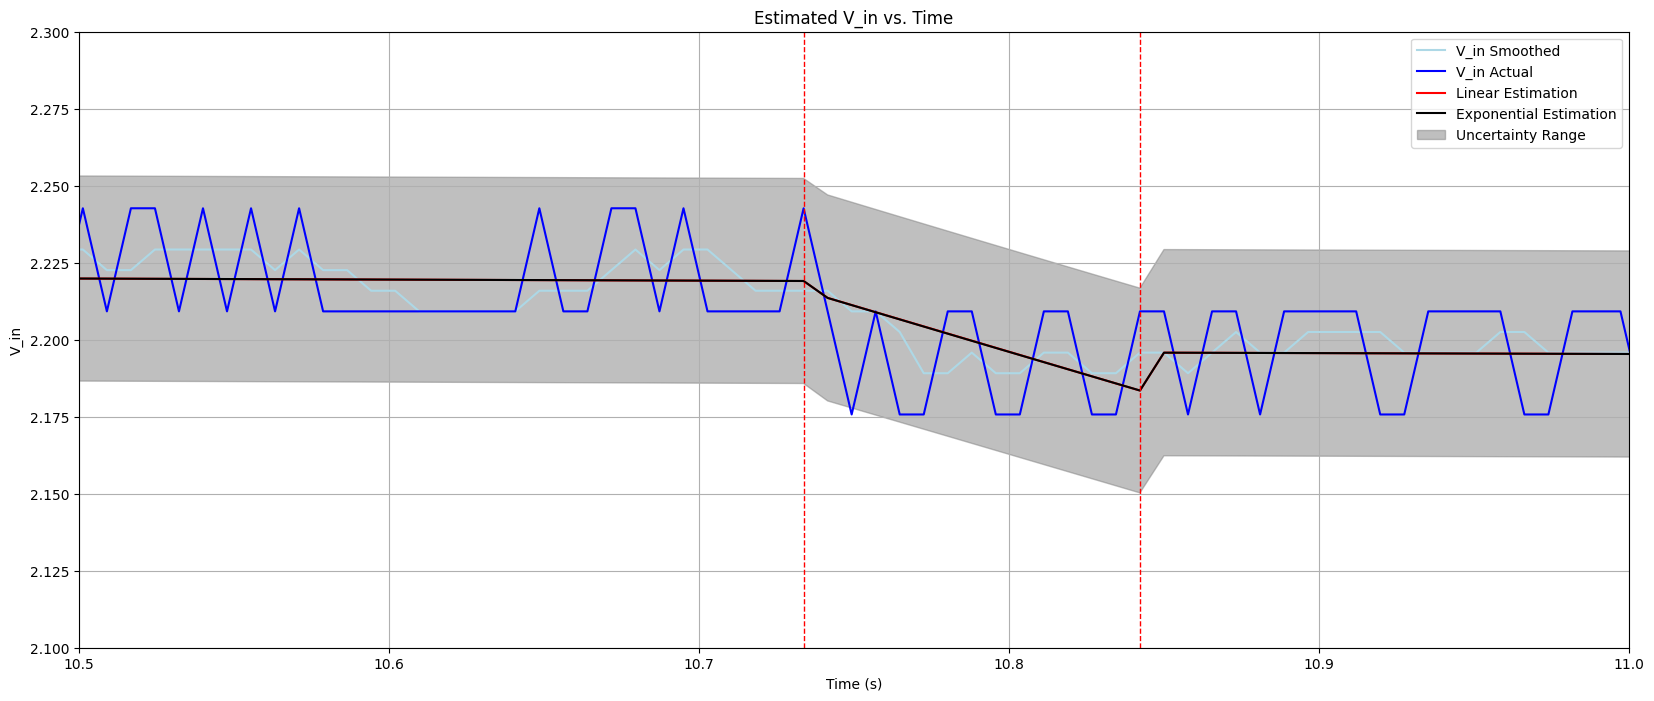

Root Mean Squared Error (RMSE) - Exponential Model: 0.020616648151502923
Root Mean Squared Error (RMSE) - Linear Model: 0.020643389192477973

Optimal Req values:
Window 1: 17.18 	 +/- 	 0.60858178450648
Window 2: 16386.3 	 +/- 	 506.20085632284986
Window 3: 184.21 	 +/- 	 18.243827076141503
Window 4: 19375.16 	 +/- 	 239.62000269732818
Window 5: 15.81 	 +/- 	 0.625915399868655
Window 6: 25940.88 	 +/- 	 1633.5034283636194
Window 7: 213.27 	 +/- 	 10.04203221806263
Window 8: 13070.01 	 +/- 	 4208.217159497174
Window 9: 131.62 	 +/- 	 6.075438579825494


In [45]:
#################################################
#                                               #
#                   Fit Models                  #
#                                               #
#################################################

delta_C = 0.005
delta_V0 = 0.033472999999999864

plt.figure(figsize=(20, 8))

# Defining models for optimization and smoothing
def model_exp(t, R):
    return initial_voltage * np.exp(-t / (R * C))

def model_lin(t, m):
    return initial_voltage - m*t

# Fit the model to the data between each pair of consecutive indices in adjusted_window_indices
optimal_Req, optimal_m = [], []
optimal_Req_uncertainties, optimal_m_uncertainties = [], []
estimations_exp, estimations_lin = [], []
times = []
V_uncertainties = []
#e^(-t/(RC)) * sqrt(delta_V0^2 + (V0 * t/(C * R^2))^2 * delta_R^2 + ()^2 * delta_C^2)

for i in range(0, len(window_indices) - 1):

    start, end = window_indices[i] - (window_size - 1), window_indices[i + 1] - (window_size - 2)
    initial_voltage = smoothed_V_in[start]
    t = adjusted_seconds[start:end] - adjusted_seconds.iloc[start]
    V = smoothed_V_in[start:end]
    initial_guess = 1

    params, covariance = curve_fit(model_exp, t, V, p0=initial_guess, bounds=(0, np.inf))
    optimal_Req.append(params[0])
    optimal_Req_uncertainties.append(np.sqrt(np.diag(covariance))[0])
    guess_exp = model_exp(t, optimal_Req[i])
    guess_exp.reset_index(inplace=True, drop=True)

    params, covariance = curve_fit(model_lin, t, V, p0=initial_guess, bounds=(0, np.inf))
    optimal_m.append(params[0])
    optimal_m_uncertainties.append(np.sqrt(np.diag(covariance))[0])
    guess_lin = model_lin(t, optimal_m[i])
    guess_lin.reset_index(inplace=True, drop=True)

    if estimations_exp:
        times.extend(t[1:] + adjusted_seconds.iloc[start])

        # Comment out the following 2 lines if you don't want to average between start/end of consecutive pieces
        # estimations_exp[-1] = (estimations_exp[-1] + guess_exp[0])/2
        # estimations_lin[-1] = (estimations_lin[-1] + guess_lin[0])/2

        estimations_exp.extend(guess_exp[1:])
        estimations_lin.extend(guess_lin[1:])
        V_uncertainties.extend(np.exp(-1 * t[1:] / (optimal_Req[-1] * C)) * np.sqrt(delta_V0**2 + (initial_voltage * t[1:] / (optimal_Req[-1]**2 * C))**2 * optimal_Req_uncertainties[-1] + (initial_voltage * t[1:] / (optimal_Req[-1] * C**2))**2 * delta_C**2))
    else:
        times.extend(t[:] + adjusted_seconds.iloc[start])
        V_uncertainties.extend(np.exp(-1 * t / (optimal_Req[-1] * C)) * np.sqrt(delta_V0**2 + (initial_voltage * t / (optimal_Req[-1]**2 * C))**2 * optimal_Req_uncertainties[-1] + (initial_voltage * t / (optimal_Req[-1] * C**2))**2 * delta_C**2))
        estimations_exp.extend(guess_exp)
        estimations_lin.extend(guess_lin)

    # plt.axvline(x=times[-1], color='b', linestyle='--', linewidth=1, zorder=3, label='Window') # Uncomment just to confirm windows are overlapping

#################################################
#                                               #
#               Plot Model Results              #
#                                               #
#################################################

# Plot the estimated model and the actual voltage readings
plt.plot(adjusted_seconds, smoothed_V_in, color='lightblue', label="V_in Smoothed")
plt.plot(adjusted_seconds, adjusted_V_in, color='blue', label="V_in Actual")
plt.plot(times, estimations_lin, color='red', label="Linear Estimation", zorder=2, linestyle='-')
plt.plot(times, estimations_exp, color='black', label="Exponential Estimation", zorder=2, linestyle='-')
times = np.array(times)
estimations_exp = np.array(estimations_exp)
V_uncertainties = np.array(V_uncertainties)
plt.fill_between(times, estimations_exp - V_uncertainties, estimations_exp + V_uncertainties, color='gray', alpha=0.5, label="Uncertainty Range")
# plt.xlim(5.5, 30)
# plt.ylim(1.5, 2.6)
plt.xlim(10.5, 11)
plt.ylim(2.1, 2.3)
plt.xlabel('Time (s)')
plt.ylabel('V_in')
plt.title('Estimated V_in vs. Time')
plt.legend()
plt.grid(True)
for index in window_indices:
    plt.axvline(x=adjusted_seconds[index], color='r', linestyle='--', linewidth=1, label='Window')
plt.show()
    
# Calculate and plot the mean squared error
mse = mean_squared_error(adjusted_V_in[window_indices[0]:window_indices[-1]], estimations_exp[:-1])
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) - Exponential Model: {rmse}")

mse_linear = mean_squared_error(adjusted_V_in[window_indices[0]:window_indices[-1]], estimations_lin[:-1])
rmse_linear = np.sqrt(mse_linear)
print(f"Root Mean Squared Error (RMSE) - Linear Model: {rmse_linear}")

# Print the estimated R values
print("\nOptimal Req values:")
for i, (Req, Runcertainty) in enumerate(zip(optimal_Req, optimal_Req_uncertainties), start=1):
    print(f"Window {i}: {round(Req, 2)} \t +/- \t {Runcertainty}")




In [53]:
a = smoothed_V_in[window_indices[0]-20]
a

# is this diff really scope precision? delta_V of 0.02 seems very high for a high precision instrument

2.4702926

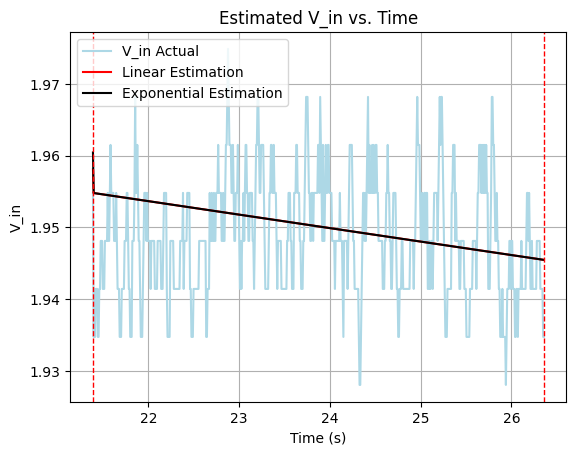

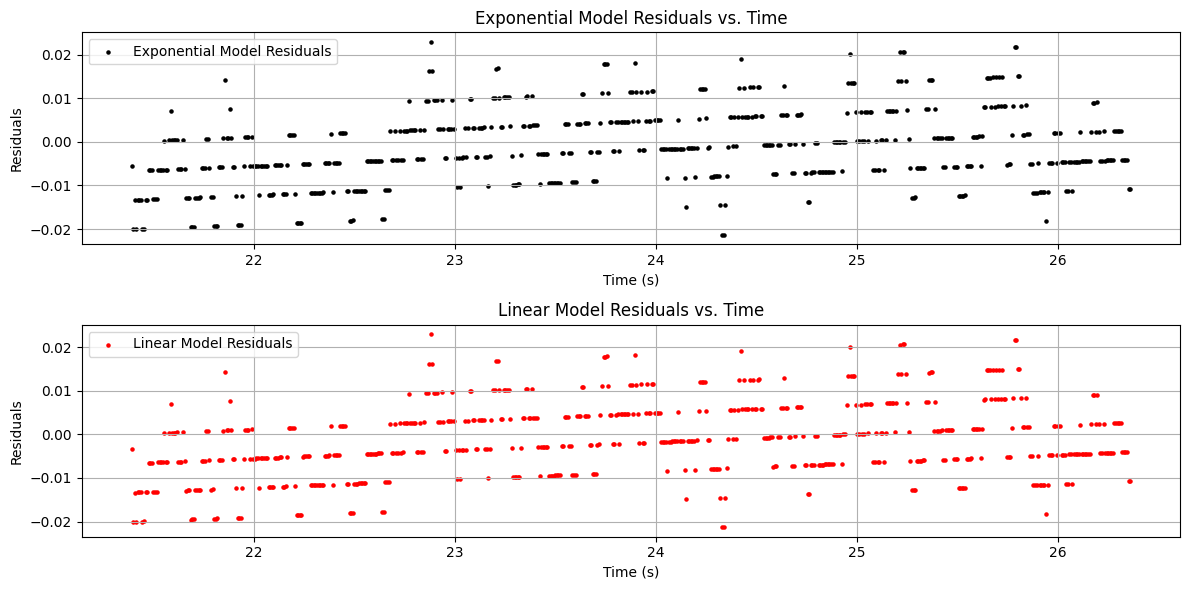

In [12]:
#################################################
#                                               #
#              Plot Model Residuals             #
#                                               #
#################################################

isolate_window = 6
window_start = window_indices[isolate_window-1] - (window_size - 1)
window_end = window_indices[isolate_window] - (window_size - 2)
offset_start = window_indices[isolate_window-1] - window_indices[0]
offset_end = window_indices[isolate_window] - window_indices[0] + 1

# Plot the estimated model and the actual voltage readings
plt.plot(adjusted_seconds[window_start:window_end], smoothed_V_in[window_start:window_end], color='lightblue', label="V_in Actual")
plt.plot(times[offset_start:offset_end], estimations_lin[offset_start:offset_end], color='red', label="Linear Estimation", linestyle='-')
plt.plot(times[offset_start:offset_end], estimations_exp[offset_start:offset_end], color='black', label="Exponential Estimation", linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel('V_in')
plt.title('Estimated V_in vs. Time')
plt.legend()
plt.grid(True)
for i, index in enumerate(window_indices):
    if isolate_window - 1 <= i <= isolate_window:
        plt.axvline(x=adjusted_seconds[index], color='r', linestyle='--', linewidth=1, label='Window')
plt.show()

# Plot residuals for the exponential model
plt.figure(figsize=(12, 6))
residuals_exp = smoothed_V_in[window_start:window_end] - estimations_exp[offset_start:offset_end]
plt.subplot(2, 1, 1)
plt.scatter(times[offset_start:offset_end], residuals_exp, color='black', label='Exponential Model Residuals', s=5)
plt.xlabel('Time (s)')
plt.ylabel('Residuals')
plt.title('Exponential Model Residuals vs. Time')
plt.legend()
plt.grid(True)

# Plot residuals for the linear model
residuals_lin = smoothed_V_in[window_start:window_end] - estimations_lin[offset_start:offset_end]
plt.subplot(2, 1, 2)
plt.scatter(times[offset_start:offset_end], residuals_lin, color='r', label='Linear Model Residuals', s=5)
plt.xlabel('Time (s)')
plt.ylabel('Residuals')
plt.title('Linear Model Residuals vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 